In [1]:
#PUT YOUR ARTIST NAME HERE, RUN THE ENTIRE FILE AND SCROLL TO THE BOTTOM

In [2]:
artist_input_name = "frank ocean"

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
access_token = os.getenv("GENIUS-API-TOKEN")
genius_headers = {
    "Authorization": f"Bearer {access_token}"
}

In [4]:
import requests
import base64
from bs4 import BeautifulSoup

In [5]:
load_dotenv()
spotify_client_id = os.getenv("SPOTIFY-CLIENT-ID")
spotify_client_secret = os.getenv("SPOTIFY-CLIENT-SECRET") 

def get_token(client_id, client_secret):
    auth_str = f"{spotify_client_id}:{spotify_client_secret}"
    b64_auth = base64.b64encode(auth_str.encode()).decode()
    
    headers = {"Authorization": f"Basic {b64_auth}"}
    data = {"grant_type": "client_credentials"}
    
    res = requests.post("https://accounts.spotify.com/api/token", data=data, headers=headers)
    return res.json()["access_token"]

spotify_token = get_token(spotify_client_id, spotify_client_secret)
spotify_headers = {"Authorization": f"Bearer {spotify_token}"}

In [6]:
'''

FINDING TOP 20 SONGS FOR THE ARTIST

'''


def search_artist_songs(artist_input_name, max_songs=20):
    base_url = "https://api.genius.com"
    search_url = f"{base_url}/search"

    params = {"q": artist_input_name}
    response = requests.get(search_url, params=params, headers=genius_headers)
    hits = response.json()["response"]["hits"]

    artist_id = None
    for hit in hits:
        song = hit["result"]
        if artist_input_name.lower() in song["primary_artist"]["name"].lower():
            artist_id = song["primary_artist"]["id"]
            artist_found=True
            break

    if not artist_id:
        print("Artist not found")
        return []

    artist_name_url = f"{base_url}/artists/{artist_id}"
    response = requests.get(artist_name_url, headers=genius_headers)
    artist_name = response.json()["response"]["artist"]["name"]
    
    songs = []
    page=1
    while len(songs)<max_songs:
        artist_songs_url = f"{base_url}/artists/{artist_id}/songs"
        params = {
            "sort": "popularity",
            "per_page": 20,
            "page": page
        }
        response = requests.get(artist_songs_url, params=params, headers=genius_headers)
        song_list = response.json()["response"]["songs"]
        
        if not song_list:
            print("Error API return")
        
        for song in song_list:
            if  artist_name.lower() in song["primary_artist"]["name"].lower() and song["title"] not in [s[0] for s in songs]:
                songs.append((song["title"], song["url"]))
                if len(songs) >= max_songs:
                    break
        page+=1

    return artist_name, songs



artist_name, top_songs = search_artist_songs(artist_input_name)
for song in top_songs: print(song)


('Thinkin Bout You', 'https://genius.com/Frank-ocean-thinkin-bout-you-lyrics')
('Nights', 'https://genius.com/Frank-ocean-nights-lyrics')
('Self Control', 'https://genius.com/Frank-ocean-self-control-lyrics')
('Pink Matter', 'https://genius.com/Frank-ocean-pink-matter-lyrics')
('Ivy', 'https://genius.com/Frank-ocean-ivy-lyrics')
('Chanel', 'https://genius.com/Frank-ocean-chanel-lyrics')
('Pyramids', 'https://genius.com/Frank-ocean-pyramids-lyrics')
('Nikes', 'https://genius.com/Frank-ocean-nikes-lyrics')
('White Ferrari', 'https://genius.com/Frank-ocean-white-ferrari-lyrics')
('Lost', 'https://genius.com/Frank-ocean-lost-lyrics')
('Super Rich Kids', 'https://genius.com/Frank-ocean-super-rich-kids-lyrics')
('Pink + White', 'https://genius.com/Frank-ocean-pink-white-lyrics')
('Bad Religion', 'https://genius.com/Frank-ocean-bad-religion-lyrics')
('Novacane', 'https://genius.com/Frank-ocean-novacane-lyrics')
('Solo', 'https://genius.com/Frank-ocean-solo-lyrics')
('Seigfried', 'https://geni

In [7]:
def get_spotify_artist_info(artist_name):
    url = f"https://api.spotify.com/v1/search"
    params = {
        "q": artist_name,
        "type": "artist",
        "limit": 1
    }
    response = requests.get(url, params=params, headers=spotify_headers)
    if response.status_code == 200:
        results = response.json()
        items = results.get("artists", {}).get("items", [])
        if items:
            artist = items[0]
            return artist["genres"],artist["popularity"], artist["images"][0]["url"] if artist["images"] else None
        else:
            print("No artist found.")
            return None
    else:
        print(f"Spotify search failed: {response.status_code}")
        return None

artist_genres, artist_popularity, artist_image = get_spotify_artist_info(artist_name)

print(" Fetched artist genres, popularity and image")

 Fetched artist genres, popularity and image


In [8]:
'''

SCRAPING LYRICS FOR A SONG FROM GENIUS.COM

'''


def get_lyrics_from_url(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, "html.parser")
    containers = soup.find_all("div", attrs={"data-lyrics-container": "true"})
    lyrics_lines = []
    for container in containers:
        for child in container.children:
            if getattr(child, "attrs", None) and child.attrs.get("data-exclude-from-selection") == "true":
                continue
            text = child.get_text(separator="\n").strip() if hasattr(child, "get_text") else str(child).strip()
            if text:
                lyrics_lines.append(text)
    #print(lyrics_lines)

    return lyrics_lines


# for title, url in top_songs:
#     lyrics = get_lyrics_from_url(url)
#     # print(f"\nTRACK: {title}")
#     # print(lyrics[:500])

In [9]:
'''

CLEANING LYRICS TO ONLY INCLUDE THE PARTS SUNG BY THE ARTIST SEARCHED

'''


import re

def clean_lyrics_lines(lyrics_lines, artist_name):
    cleaned_lines = []
    skip_block = False
    inside_tag_block = False
    tag_buffer = []

    for line in lyrics_lines:
        line = line.strip()

        # Handle multi-line tags: start of a section
        if line.startswith("["):
            inside_tag_block = True
            tag_buffer = [line]
            if line.endswith("]"):  # single-line tag
                inside_tag_block = False
        elif inside_tag_block:
            tag_buffer.append(line)
            if line.endswith("]"):  # tag closed
                inside_tag_block = False

        if not inside_tag_block and tag_buffer:
            full_tag = " ".join(tag_buffer).strip("[]").lower()
            tag_buffer = []


            # Check if this is a labeled section (Verse, Chorus, etc.)
            if ":" in full_tag:
                label, artists = full_tag.split(":", 1)
                artists = artists.strip()
                first_artist = re.split(r"[,&]", artists)[0].strip()
                main = artist_name.lower() if artist_name else ""
                skip_block = not (artists.startswith(artist_name.lower()))
                
            else:
                # unlabeled tag like [Part I] – keep
                skip_block = False

            continue  # always skip tag lines

        # Skip any lines still in the middle of a header
        if inside_tag_block:
            continue

        # Skip non-tag lyrics from rejected blocks
        if skip_block:
            continue

        # Otherwise, keep lyric lines
        if line and not re.match(r"\[.*?\]", line):
            cleaned_lines.append(line.lower())

    return cleaned_lines


In [10]:
'''

CALCULATING SENTIMENT PER LINE AND AVERAGE SENTIMENT

'''


from textblob import TextBlob

def get_sentiment_scores(lines):
    sentiments_with_0s = []
    for line in lines:
        if line.strip():
            polarity = TextBlob(line).sentiment.polarity
            sentiments_with_0s.append(polarity)
    
    sentiments = [i for i in sentiments_with_0s if i!=0]
    
    average_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
    return sentiments, average_sentiment


In [11]:
'''

PLOTTING SENTIMENT OVER TIME (FOR EACH SONG)

'''

import matplotlib.pyplot as plt

def plot_sentiment_trajectory(sentiments, title="Sentiment Trajectory"):
    plt.figure(figsize=(10, 4))
    plt.plot(sentiments, marker="o", linestyle="-", alpha=0.7)
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Line Number")
    plt.ylabel("Sentiment Polarity")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


In [12]:
'''

FINDING TOP BIGRAMS/TRIGRAMS

'''


from nltk.util import ngrams

def get_top_ngrams(tokens, n=2, top_k=10):
    ngram_list = list(ngrams(tokens, n))
    ngram_counts = Counter(ngram_list)
    return ngram_counts.most_common(top_k)

In [13]:
from pprint import pprint
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

def analyze_lyrics(lines):
    doc = nlp("\n".join(lines))

    words = [token.text for token in doc if token.is_alpha]
    lexical_diversity = len(set(words)) / len(words) if words else 0

    lines_tokenized = [nlp(line) for line in lines if line.strip()]
    avg_line_length = sum(len([t for t in d if t.is_alpha]) for d in lines_tokenized) / len(lines_tokenized)

    pos_counts = Counter(token.pos_ for token in doc if token.is_alpha)

    tense_counts = Counter(token.tag_ for token in doc if token.tag_.startswith("VB"))

    sentiments, avg_sentiment = get_sentiment_scores(lines)

    top_bigrams = get_top_ngrams(words, n=2)
    top_trigrams = get_top_ngrams(words, n=3)

    
    return {
        "lexical_diversity": lexical_diversity,
        "average_line_length": avg_line_length,
        "pos_distribution": dict(pos_counts),
        "verb_tense_counts": dict(tense_counts),
        "line_sentiments": sentiments,
        "average_sentiment": avg_sentiment,
        "top_bigrams": top_bigrams,
        "top_trigrams": top_trigrams,
    }, words

all_songs_data = []


for title, url in top_songs:
    lyrics = get_lyrics_from_url(url)
    cleaned = clean_lyrics_lines(lyrics, artist_name)
    metrics, tokens = analyze_lyrics(cleaned)
    all_songs_data.append({
        "title": title,
        "cleaned_lines": cleaned,
        "metrics": metrics
    })
    # plot_sentiment_trajectory(metrics["line_sentiments"], title=f"{title} — Sentiment Flow")
print("Finished analyzing each song")

Finished analyzing each song


In [14]:
all_cleaned_lines = []
for song in all_songs_data:
    all_cleaned_lines.extend(song["cleaned_lines"])

full_lyrics_text = "\n".join(all_cleaned_lines)

In [15]:
def get_question_vs_statement_counts(lines):
    question_lines = 0
    statement_lines = 0

    for line in lines:
        line = line.strip()
        if not line:
            continue

        if "?" in line:
            question_lines += line.count("?")
        else:
            statement_lines += 1

    total = question_lines + statement_lines
    return question_lines / total if total else 0


In [16]:
def aggregate_artist_profile(song_data_list, lines):
    n_songs = len(song_data_list)

    sum_lexical_div = 0
    total_sentiment = 0
    sentiments_per_song = []

    pos_counts = Counter()
    verb_counts = Counter()

    for song in song_data_list:
        m = song["metrics"]
        sum_lexical_div += m["lexical_diversity"]
        total_sentiment += m["average_sentiment"]
        sentiments_per_song.append(m["average_sentiment"])

        pos_counts.update(m["pos_distribution"])
        verb_counts.update(m["verb_tense_counts"])

    doc = nlp("\n".join(lines))

    words = [token.text for token in doc if token.is_alpha]

    lines_tokenized = [nlp(line) for line in lines if line.strip()]
    avg_line_length = sum(len([t for t in d if t.is_alpha]) for d in lines_tokenized) / len(lines_tokenized)

    top_bigrams = get_top_ngrams(words, n=2)
    top_trigrams = get_top_ngrams(words, n=3)

    question_statement_ratio = get_question_vs_statement_counts(lines)
    
    return {
        "name": artist_name,
        "average_lexical_diversity": sum_lexical_div / n_songs if n_songs else 0,
        "average_line_length": avg_line_length,
        "average_sentiment": total_sentiment / n_songs if n_songs else 0,
        "sentiments_per_song": sentiments_per_song,
        "pos_distribution": dict(pos_counts),
        "verb_tense_distribution": dict(verb_counts),
        "top_bigrams": top_bigrams[:3],
        "top_trigrams": top_trigrams[:3],
        "top_songs":[i for i, _ in top_songs],
        "genres": artist_genres,
        "popularity_score": artist_popularity,
        "question_statement_ratio": question_statement_ratio,
        "profile_image": artist_image
    }

artist_profile = aggregate_artist_profile(all_songs_data, all_cleaned_lines)

In [17]:
def extract_all_content_words(lines, nlp):
    all_words = []
    for line in lines:
        doc = nlp(line)
        words = [
            token.lemma_ for token in doc
            if token.pos_ in {"NOUN", "ADJ", "PROPN"}
            and not token.is_stop and token.is_alpha
        ]
        all_words.extend(words)
    return all_words

def get_top_content_words(words, top_n=30):
    return [word for word, count in Counter(words).most_common(top_n)]


all_words = extract_all_content_words(all_cleaned_lines, nlp)
word_counts = Counter(all_words)
imp_words = [word for word in all_words if word_counts[word] > 2]
top_words = get_top_content_words(all_words, 40)

In [18]:
def embed_words_with_spacy(words, nlp):
    return [nlp(word).vector for word in words]

from sklearn.cluster import KMeans

def cluster_words(words, vectors, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(vectors)

    clusters = [[] for _ in range(n_clusters)]
    for word, label in zip(words, labels):
        clusters[label].append(word)
    
    return clusters

vectors = embed_words_with_spacy(top_words, nlp)
clusters = cluster_words(top_words, vectors, n_clusters=3)

In [19]:
import os
from openai import OpenAI

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI-API-KEY"))

def name_topics_with_openai(topic_groups):
    named_topics = []
    for group in topic_groups:
        prompt = f"Give a short (1–4 word) name for a lyrical theme/topic for artist {artist_name} based on these words: {', '.join(group)}"
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}]
        )
        name = response.choices[0].message.content.strip()
        named_topics.append({"name": name, "keywords": group[:5]})
    return named_topics

named_topics = name_topics_with_openai(clusters)
artist_profile["topics"] = named_topics

In [20]:
summary_prompt = f"""
Generate a 1-3 sentence description of an artist's lyrical style based on the following:
- Artist: {artist_name}
- Average lexical diversity: {str(artist_profile["average_lexical_diversity"])}
- Sentiment values per song: {', '.join(map(str, artist_profile["sentiments_per_song"]))}
- POS distribution: {str(artist_profile["pos_distribution"])}
- Verb tense distribution: {str(artist_profile["verb_tense_distribution"])}
- Key themes and words: {str(artist_profile["topics"])}
- Question to statement ratio: {str(artist_profile["question_statement_ratio"])}
"""

summary_response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": summary_prompt}]
)
summary = summary_response.choices[0].message.content.strip()

artist_profile["ai_summary"] = summary

In [21]:
print(summary)

Frank Ocean's lyrical style is characterized by a poignant blend of introspection and emotional nuance, weaving together vivid imagery and thoughtful reflections on love and reality. With a strong focus on personal experiences, his lyrics exhibit moderate lexical diversity, utilizing a rich array of nouns and verbs to evoke the complexities of human emotions, often set against a backdrop of nighttime musings and dreamlike scenarios. His ability to oscillate between upbeat sentiments and contemplative tones creates a captivating listening experience that resonates deeply with listeners.


In [22]:
def plot_pos_pie(pos_dict):
    label_map = {
        'ADJ': 'Adjectives',
        'ADP': 'Prepositions',
        'ADV': 'Adverbs',
        'AUX': 'Auxiliary Verbs',
        'CCONJ': 'Coordinating Conjunctions',
        'DET': 'Determiners',
        'INTJ': 'Interjections',
        'NOUN': 'Nouns',
        'NUM': 'Numbers',
        'PART': 'Particles',
        'PRON': 'Pronouns',
        'PROPN': 'Proper Nouns',
        'SCONJ': 'Subordinating Conjunctions',
        'VERB': 'Verbs',
        'X': 'Other (Unknown)'
    }

    total = sum(pos_dict.values())
    grouped = {}
    other_total = 0

    for tag, count in pos_dict.items():
        percentage = count / total
        if percentage < 0.05:
            other_total += count
        else:
            label = label_map.get(tag, tag)
            grouped[label] = count

    if other_total > 0:
        grouped["Other"] = other_total

    labels = list(grouped.keys())
    sizes = list(grouped.values())

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, textprops={'fontsize': 12})
    plt.axis("equal")
    plt.title("Part of Speech Distribution", fontsize=14)
    plt.show()

In [23]:
def plot_verb_tense_pie(tense_dict):
    label_map = {
        'VB': 'Base Form',
        'VBD': 'Past Tense',
        'VBG': 'Gerund/Present Participle',
        'VBN': 'Past Participle',
        'VBP': 'Present (Non-3rd Sing.)',
        'VBZ': 'Present (3rd Sing.)'
    }

    total = sum(tense_dict.values())
    grouped = {}
    other_total = 0

    for tag, count in tense_dict.items():
        percentage = count / total
        if percentage < 0.1:
            other_total += count
        else:
            label = label_map.get(tag, tag)
            grouped[label] = count

    if other_total > 0:
        grouped["Other"] = other_total

    labels = list(grouped.keys())
    sizes = list(grouped.values())

    plt.figure(figsize=(7, 7))
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, textprops={'fontsize': 12})
    plt.axis("equal")
    plt.title("Verb Tense Usage", fontsize=14)
    plt.show()


In [24]:
from wordcloud import WordCloud

def plot_word_cloud(words):
    text = " ".join(words)
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word cloud of {artist_name} Lyrics")
    plt.show()

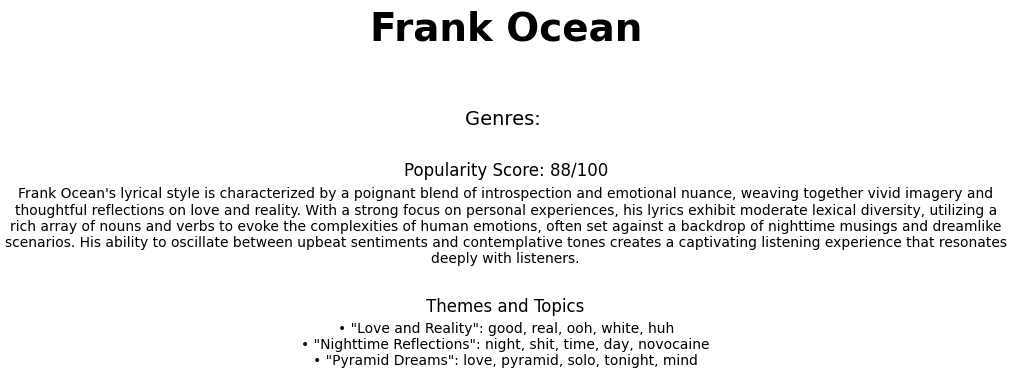

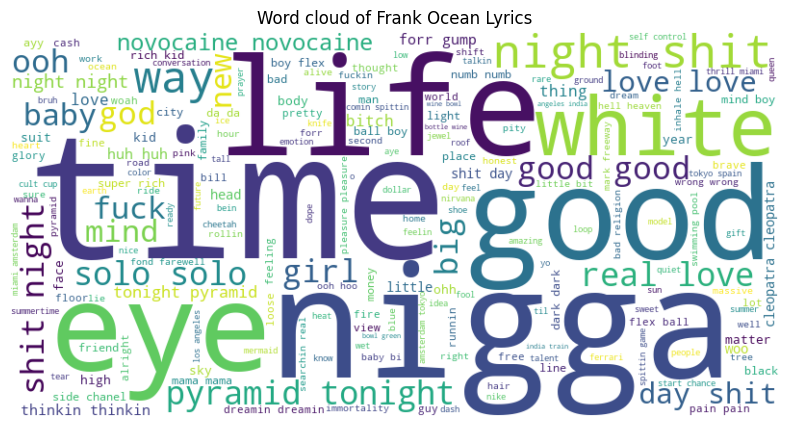

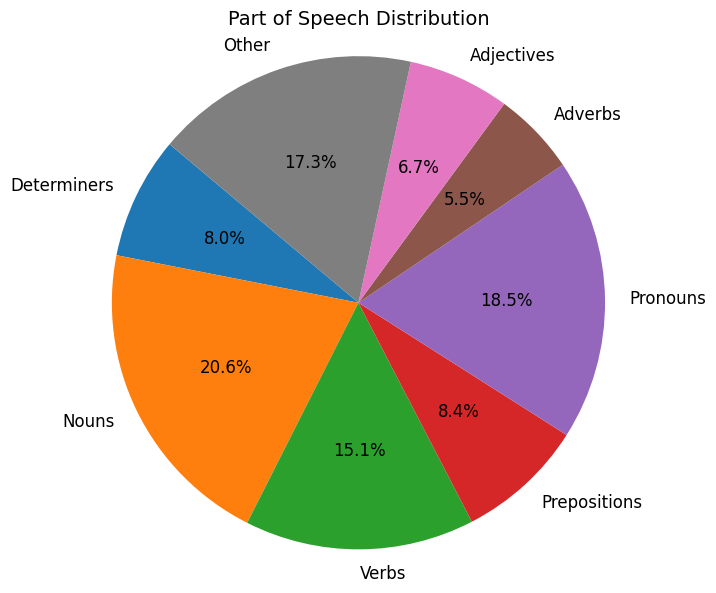

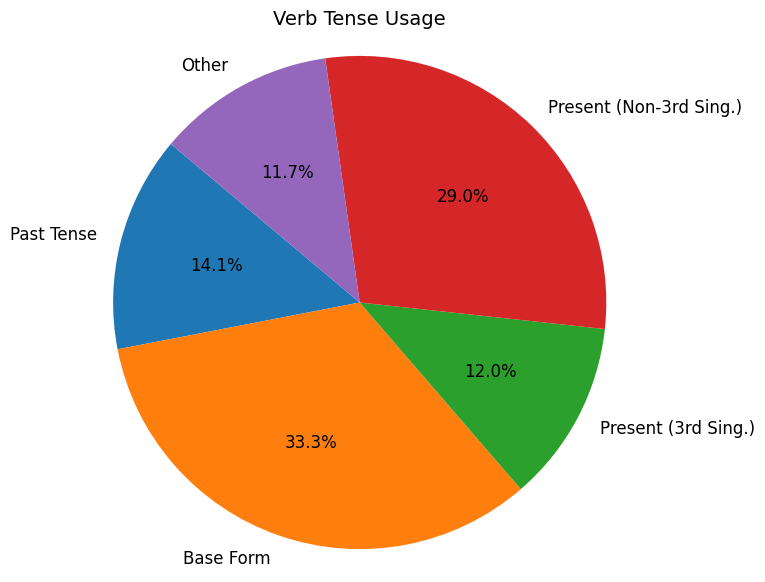


 Additional Metrics:
• Avg. Lexical Diversity: 0.399
• Avg. Line Length: 13.50 words
• Avg. Sentiment: 0.103

 Top Bigrams:
• in the (38×)
• oh oh (35×)
• i do (30×)

 Top Trigrams:
• working at the (26×)
• at the pyramid (26×)
• oh oh oh (20×)

 Top Songs:
• Thinkin Bout You
• Nights
• Self Control
• Pink Matter
• Ivy
• Chanel
• Pyramids
• Nikes
• White Ferrari
• Lost
• Super Rich Kids
• Pink + White
• Bad Religion
• Novacane
• Solo
• Seigfried
• Forrest Gump
• Godspeed
• Swim Good
• Futura Free


In [25]:
from IPython.display import Image, display

def show_artist_header():
    name = artist_profile['name']
    genres = ", ".join(artist_profile['genres'])
    popularity = artist_profile['popularity_score']

    plt.figure(figsize=(10, 4))
    plt.axis("off")
    plt.text(0.5, 1, name, fontsize=28, fontweight='bold', ha='center')
    plt.text(0.5, 0.75, f"Genres: {genres}", fontsize=14, ha='center')
    plt.text(0.5, 0.6, f"Popularity Score: {popularity}/100", fontsize=12, ha='center')

    summary_text = artist_profile['ai_summary']
    plt.text(0.5, 0.35, summary_text, fontsize=10, ha='center', wrap=True)

    topics = artist_profile['topics']
    topic_text = "\n".join([f"• {t['name']}: {', '.join(t['keywords'])}" for t in topics])
    plt.text(0.5, 0.2, "Themes and Topics", fontsize=12, ha='center')
    plt.text(0.5, 0.05, topic_text, fontsize=10, ha='center', wrap=True)

    plt.tight_layout()
    plt.show()


def display_artist_summary():
    show_artist_header()

    if artist_profile["profile_image"]:
        display(Image(url=artist_profile['profile_image'], width=300))
    
    plot_word_cloud(imp_words)
    plot_pos_pie(artist_profile["pos_distribution"])
    plot_verb_tense_pie(artist_profile["verb_tense_distribution"])


    print("\n Additional Metrics:")
    print(f"• Avg. Lexical Diversity: {artist_profile['average_lexical_diversity']:.3f}")
    print(f"• Avg. Line Length: {artist_profile['average_line_length']:.2f} words")
    print(f"• Avg. Sentiment: {artist_profile['average_sentiment']:.3f}")

    print("\n Top Bigrams:")
    for (w1, w2), count in artist_profile["top_bigrams"][:5]:
        print(f"• {w1} {w2} ({count}×)")

    print("\n Top Trigrams:")
    for (w1, w2, w3), count in artist_profile["top_trigrams"][:5]:
        print(f"• {w1} {w2} {w3} ({count}×)")

    print("\n Top Songs:")
    for title, _ in top_songs:
        print(f"• {title}")

display_artist_summary()